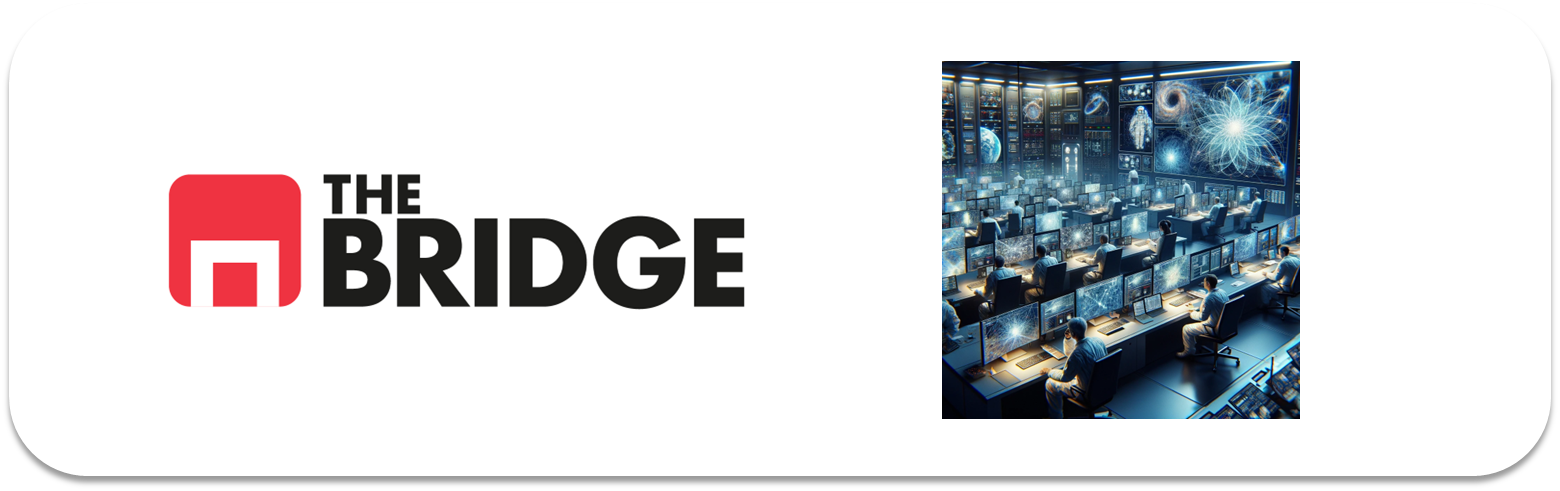

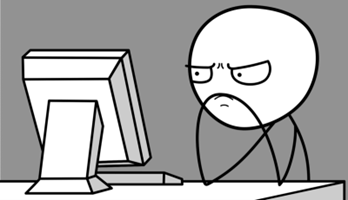

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle

from tensorflow.keras import Model
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
TRAIN_PATH = './data/apples/Train'
TEST_PATH = './data/apples/Test'

Cargamos los datos de train

In [3]:
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    
    print("Carpeta:", category)
    
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        
        X_train.append(img)
        y_train.append(category)

X_train = np.array(X_train)
y_train = np.array(y_train)

Carpeta: Braeburn
Carpeta: CrimsonSnow
Carpeta: Golden1
Carpeta: Golden2
Carpeta: Golden3
Carpeta: GrannySmith
Carpeta: PinkLady
Carpeta: Red1
Carpeta: Red2
Carpeta: Red3
Carpeta: RedDelicious
Carpeta: RedYellow1
Carpeta: RedYellow2


In [4]:
print("Tamaño X_train:", X_train.shape)
print("Tamaño y_train:", y_train.shape)

Tamaño X_train: (6404, 32, 32, 3)
Tamaño y_train: (6404,)


Tenemos 6404 imagenes de 32x32 con tres canales en train

Cargamos los datos de test

In [5]:
X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    
    print("Carpeta:", category)
    
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        
        X_test.append(img)
        y_test.append(category)

X_test = np.array(X_test)
y_test = np.array(y_test)

Carpeta: Braeburn
Carpeta: CrimsonSnow
Carpeta:

 Golden1
Carpeta: Golden2
Carpeta: Golden3
Carpeta: GrannySmith
Carpeta: PinkLady
Carpeta: Red1
Carpeta: Red2
Carpeta: Red3
Carpeta: RedDelicious
Carpeta: RedYellow1
Carpeta: RedYellow2


In [6]:
print("Tamaño X_test:", X_test.shape)
print("Tamaño y_test:", y_test.shape)

Tamaño X_test: (2134, 32, 32, 3)
Tamaño y_test: (2134,)


Tenemos 2134 imagenes de 32x32 con tres canales en test

Además, creamos el test con mayor resolución (224x224) para hacer el Zero Shot Learning con ResNetv50, que exige ese tamaño

In [7]:
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    
    print("Carpeta:", category)
    
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        
        X_test_224.append(img)
        y_test_224.append(category)

X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

Carpeta: Braeburn
Carpeta: CrimsonSnow


Carpeta: Golden1
Carpeta: Golden2
Carpeta: Golden3
Carpeta: GrannySmith
Carpeta: PinkLady
Carpeta: Red1
Carpeta: Red2
Carpeta: Red3
Carpeta: RedDelicious
Carpeta: RedYellow1
Carpeta: RedYellow2


In [8]:
print("Tamaño X_test_224:", X_test_224.shape)
print("Tamaño y_test_224:", y_test_224.shape)

Tamaño X_test_224: (2134, 224, 224, 3)
Tamaño y_test_224: (2134,)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [9]:
def show_images_batch(apples, names = [], n_cols = 5, size_scale = 2):
    
    n_rows = ((len(apples) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    
    for index, apple in enumerate(apples):
        
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(apple)
        plt.axis("off")
        
        if len(names):
            plt.title(names[index])

Visualizamos 15 imagenes de 32x32

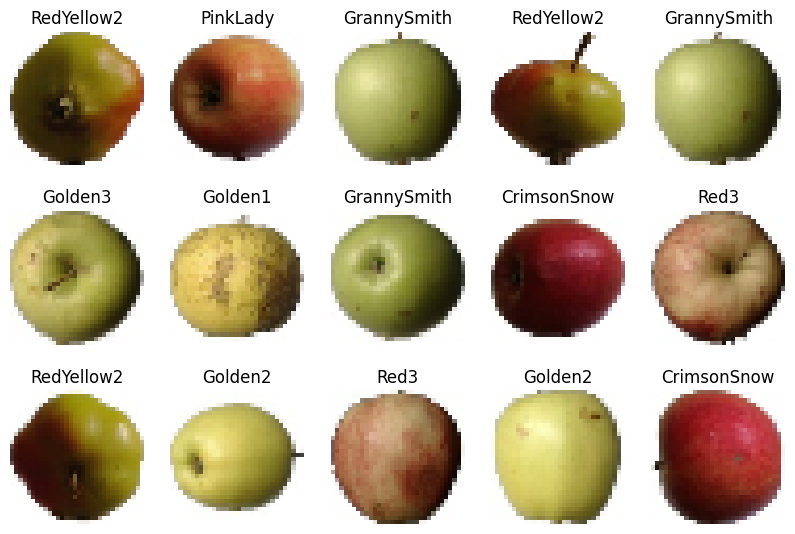

In [10]:
indices = np.random.randint(0,len(X_train), 15)
show_images_batch(X_train[indices], y_train[indices])

Visualizamos 15 imagenes de 224x224

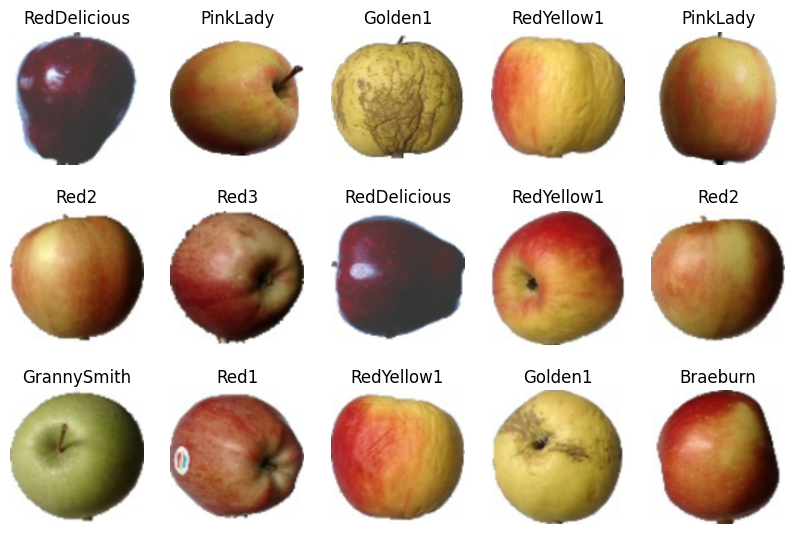

In [11]:
indices = np.random.randint(0,len(X_test_224), 15)
show_images_batch(X_test_224[indices], y_test_224[indices])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [12]:
pd.Series(y_train).value_counts(normalize = True)

RedYellow2      0.104934
Braeburn        0.076827
Golden2         0.076827
GrannySmith     0.076827
Red1            0.076827
Red2            0.076827
RedYellow1      0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

Hay 13 clases y una distribución uniforme más o menos para todas salvo para la RedYellow2 que es un poco más mayoritaria. Vamos a emplear la métrica de *accuracy*

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [13]:
# Escalamos las imágenes
X_train = X_train / 255
X_test = X_test / 255

In [14]:
# Barajamos los datos de train
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [15]:
# Mapeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [16]:
mapping

{'Braeburn': 0,
 'CrimsonSnow': 1,
 'Golden1': 2,
 'Golden2': 3,
 'Golden3': 4,
 'GrannySmith': 5,
 'PinkLady': 6,
 'Red1': 7,
 'Red2': 8,
 'Red3': 9,
 'RedDelicious': 10,
 'RedYellow1': 11,
 'RedYellow2': 12}

In [17]:
inverse_mapping

{0: 'Braeburn',
 1: 'CrimsonSnow',
 2: 'Golden1',
 3: 'Golden2',
 4: 'Golden3',
 5: 'GrannySmith',
 6: 'PinkLady',
 7: 'Red1',
 8: 'Red2',
 9: 'Red3',
 10: 'RedDelicious',
 11: 'RedYellow1',
 12: 'RedYellow2'}

In [18]:
# Mapeamos las etiquetas
y_train_s_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [19]:
base_model = ResNet50V2(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

In [20]:
seleccion = np.random.randint(0, len(X_test_224), 20)
predictions = base_model.predict(X_test_224[seleccion])

1/1 [==============================] - 1s 1s/step


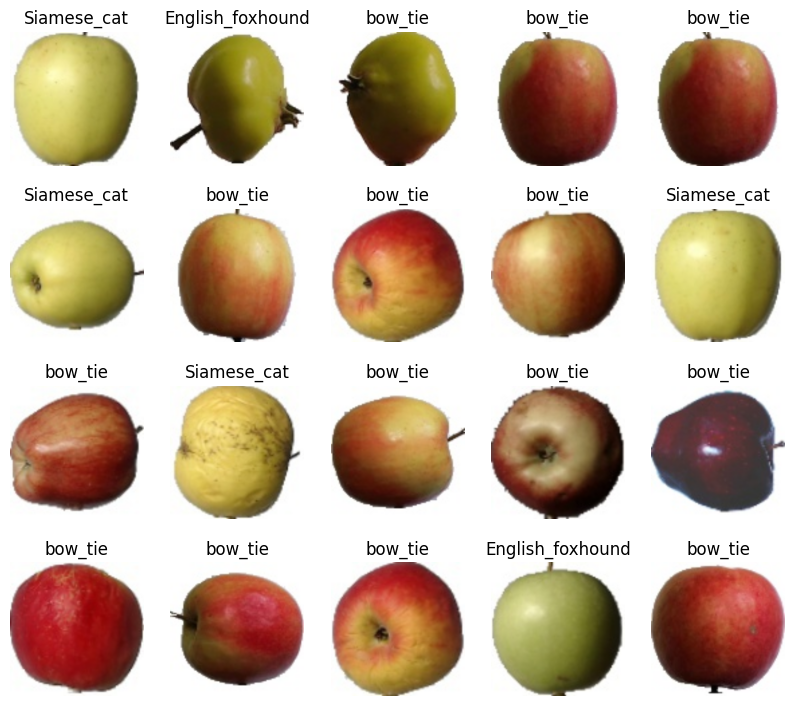

In [21]:
clase = [decodificado[0][1] for decodificado in decode_predictions(predictions)]
show_images_batch(X_test_224[seleccion], names = clase)

Lo que se esperaba, sale un desastre porque las clases del modelo no coinciden con las nuestras. Es necesario hacer *transfer learning* o *fine tunning*

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [22]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

In [23]:
def prepare_model(model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    
    # Capa de flatenizado de la salida del modelo base
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    
    return model

In [24]:
model = prepare_model(model = base_model)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                             

 tchNormalization)                                                                                
                                                                                                  
 conv2_block2_preact_relu (  (None, 8, 8, 256)            0         ['conv2_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block2_1_conv (Conv2  (None, 8, 8, 64)             16384     ['conv2_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block2_1_bn (BatchNo  (None, 8, 8, 64)             256       ['conv2_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
          

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [25]:
earlyS = EarlyStopping(patience= 5, restore_best_weights= True)

In [26]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 200
Batch_size: 64, num_steps_per_epoch: 100
Batch_size: 96, num_steps_per_epoch: 67
Batch_size: 128, num_steps_per_epoch: 50


Intuitivamente, escogemos *batch_size=64* para tener un *num_steps_per_epoch=100*

In [27]:
batch_size = 64

In [28]:
model = prepare_model(model = base_model)

history = model.fit(X_train_s, 
                    y_train_s_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=20,
                    callbacks=[earlyS])

Epoch 1/20




81/81 [==============================] - 13s 135ms/step - loss: 1.0999 - acc: 0.6674 - val_loss: 0.2621 - val_acc: 0.9461
Epoch 2/20
81/81 [==============================] - 10s 118ms/step - loss: 0.3004 - acc: 0.9079 - val_loss: 0.1009 - val_acc: 0.9899
Epoch 3/20
81/81 [==============================] - 9s 115ms/step - loss: 0.1473 - acc: 0.9602 - val_loss: 0.0545 - val_acc: 0.9938
Epoch 4/20
81/81 [==============================] - 9s 116ms/step - loss: 0.1102 - acc: 0.9692 - val_loss: 0.0415 - val_acc: 0.9938
Epoch 5/20
81/81 [==============================] - 10s 121ms/step - loss: 0.0724 - acc: 0.9822 - val_loss: 0.0226 - val_acc: 0.9992
Epoch 6/20
81/81 [==============================] - 10s 122ms/step - loss: 0.0532 - acc: 0.9879 - val_loss: 0.0170 - val_acc: 0.9984
Epoch 7/20
81/81 [==============================] - 9s 116ms/step - loss: 0.0428 - acc: 0.9902 - val_loss: 0.0129 - val_acc: 0.9984
Epoch 8/20
81/81 [==============================] - 9s 114ms/step - loss: 0.0382 

In [29]:
evol = pd.DataFrame(history.history)
evol

,loss,acc,val_loss,val_acc
0,1.099872,0.667382,0.262119,0.946136
1,0.300394,0.907866,0.100904,0.989852
2,0.147284,0.960180,0.054529,0.993755
3,0.110235,0.969159,0.041534,0.993755
4,0.072405,0.982237,0.022570,0.999219
5,0.053206,0.987898,0.017008,0.998439
6,0.042839,0.990240,0.012949,0.998439
7,0.038210,0.990631,0.013402,0.996877
8,0.026965,0.994730,0.013202,0.997658
9,0.032850,0.991411,0.010742,0.999219


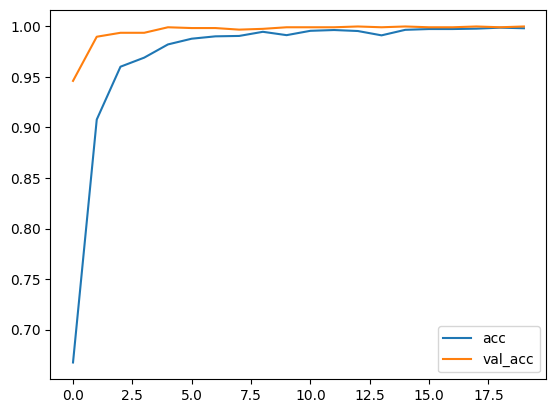

In [30]:
evol[["acc","val_acc"]].plot();

A partir de la época 5 ya se alcanza el *overfitting*

<Axes: >

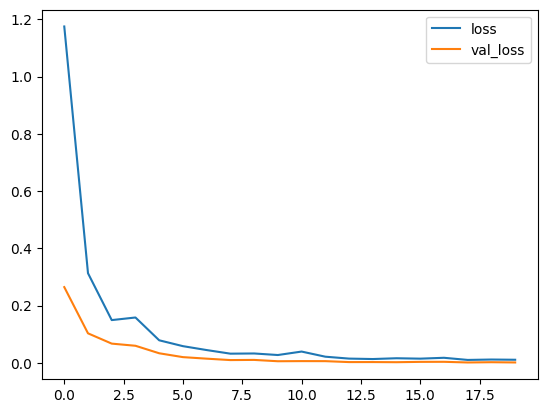

In [39]:
evol[["loss","val_loss"]].plot()

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [31]:
model.evaluate(X_test, y_test_num)

67/67 [==============================] - 5s 72ms/step - loss: 0.7535 - acc: 0.8402


[0.7534734010696411, 0.8402062058448792]

Baja el *accuracy* con respecto a validación (normal, porque se ha hecho *overfitting*), pero obtenemos un 84% que no está nada mal

In [32]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]

print(classification_report(y_test, y_pred))

67/67 [==============================] - 6s 83ms/step
              precision    recall  f1-score   support

    Braeburn       0.69      0.99      0.82       164
 CrimsonSnow       0.81      0.87      0.84       148
     Golden1       0.73      1.00      0.85       160
     Golden2       1.00      0.76      0.86       164
     Golden3       0.61      0.68      0.65       161
 GrannySmith       1.00      0.79      0.88       164
    PinkLady       0.71      0.80      0.76       152
        Red1       0.95      0.76      0.85       164
        Red2       0.72      0.53      0.61       164
        Red3       0.93      0.67      0.78       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       0.92      0.99      0.96       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.84      2134
   macro avg       0.85      0.83      0.83      2134
weighted avg       0.86      0.84      0.84      2134



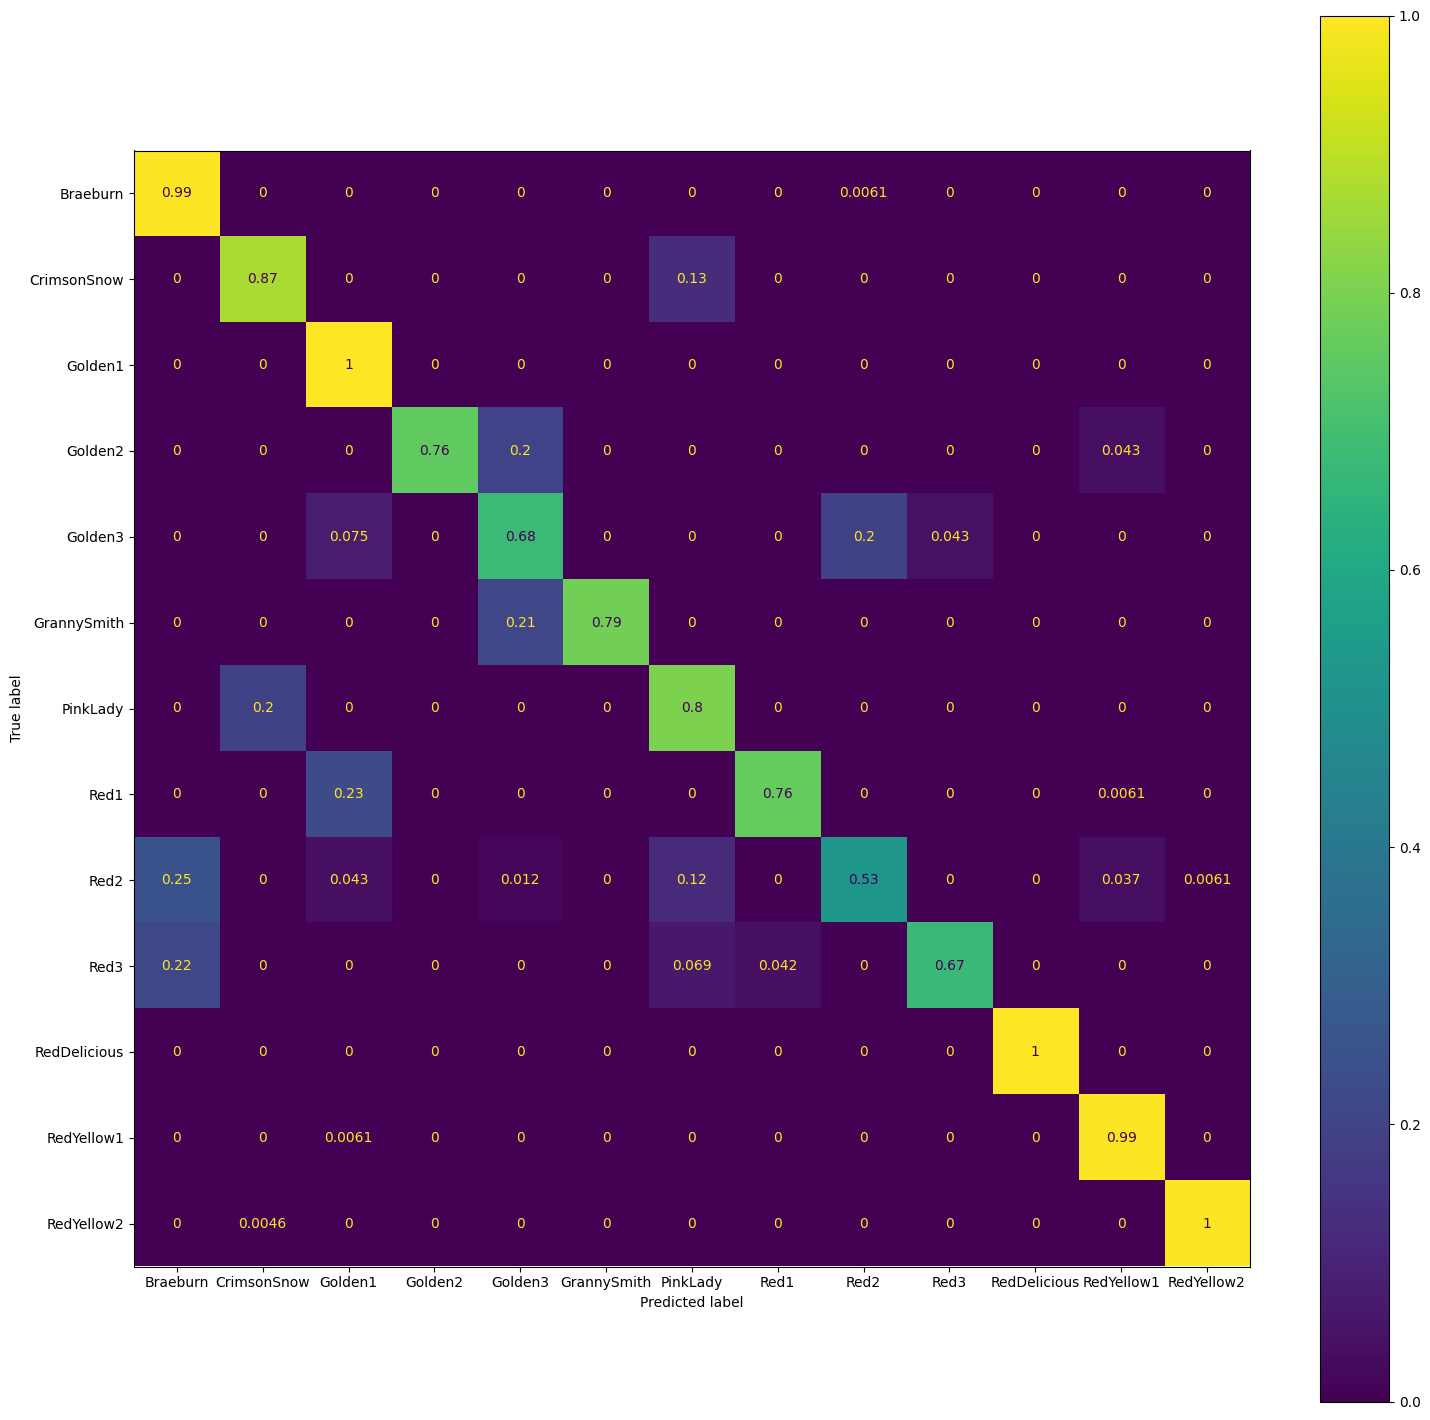

In [33]:
fig,axs = plt.subplots(1,1,figsize = (18,18))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs);

Obtenemos unos resultados bastante buenos, con algunas excepciones para la clase Golden3 que la confunde con la clase Red2 y las clases Red2 y Red3 que las confunde con la clase Braeburn

Vemos algunos de los errores a partir de un DataFrame de resultados

In [34]:
resultados = pd.DataFrame({"True": y_test, "Predicted": y_pred})

errores = resultados["True"] != resultados["Predicted"]
es_Golden3 = resultados["True"] == "Golden3"
predicted_Red2 = resultados["Predicted"] == "Red2"
es_Red2 = resultados["True"] == "Red2"

Mostramos las Golden3 (peor clase detectada) que ha confundido con Red2

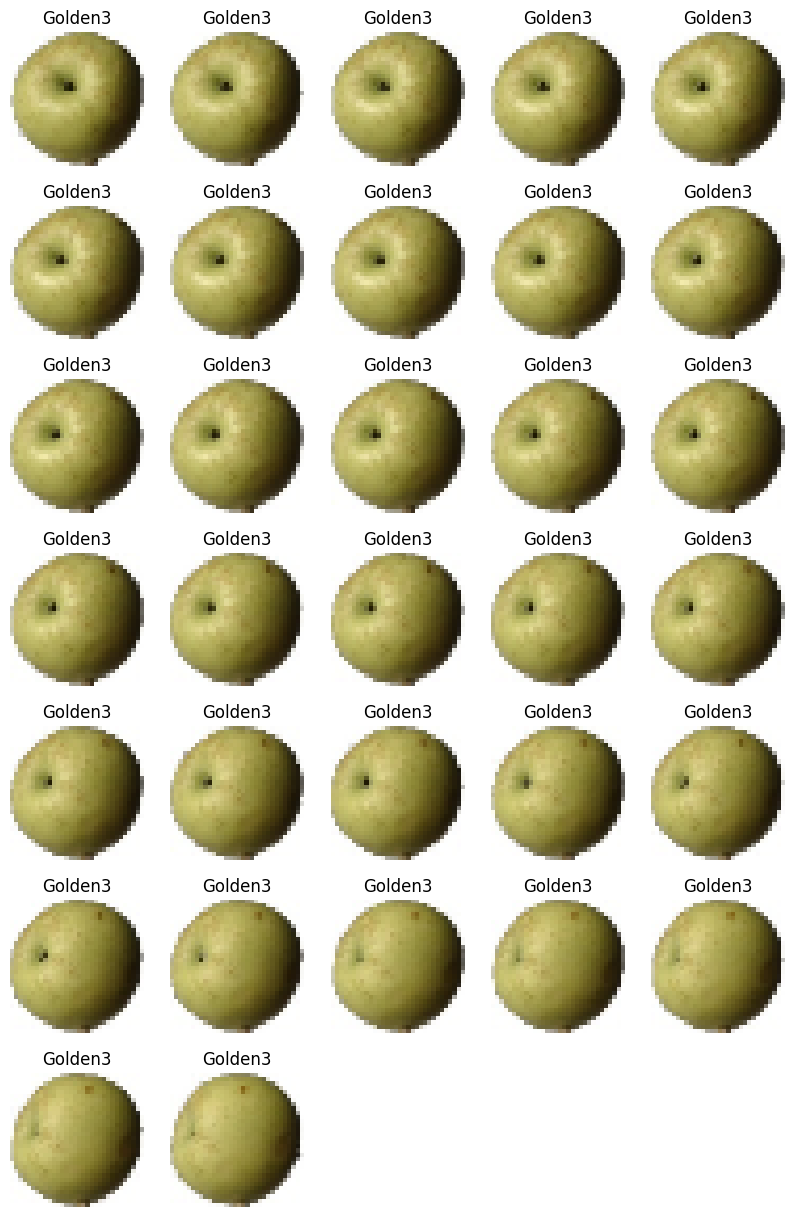

In [35]:
show_images_batch(X_test[resultados[es_Golden3 & predicted_Red2].index], y_test[resultados[es_Golden3 & predicted_Red2].index])

Para comparar, unas Red2 que detecta correctamente

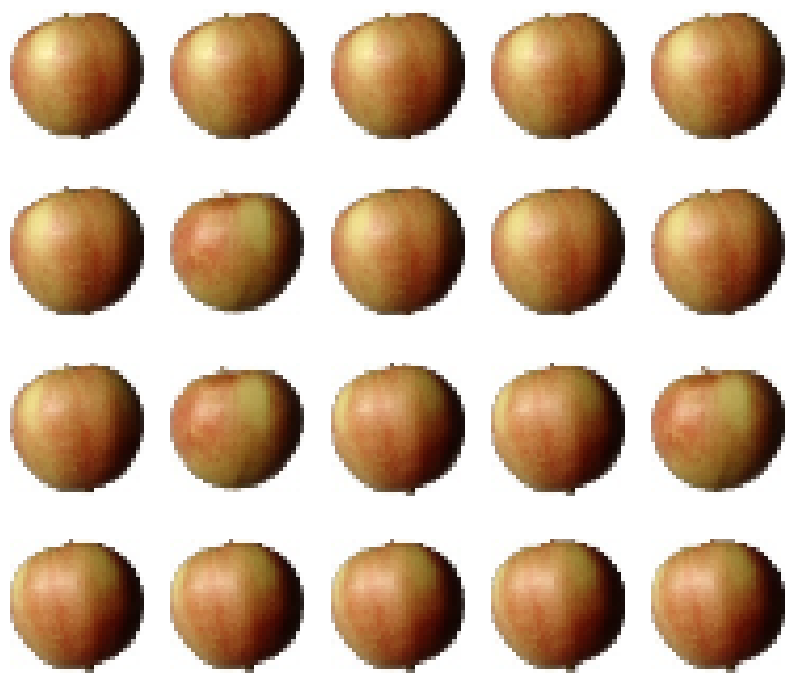

In [36]:
show_images_batch(X_test[resultados[es_Red2 & predicted_Red2].index[20:40]])

Por último, algunas Golden3 bien etiquetadas

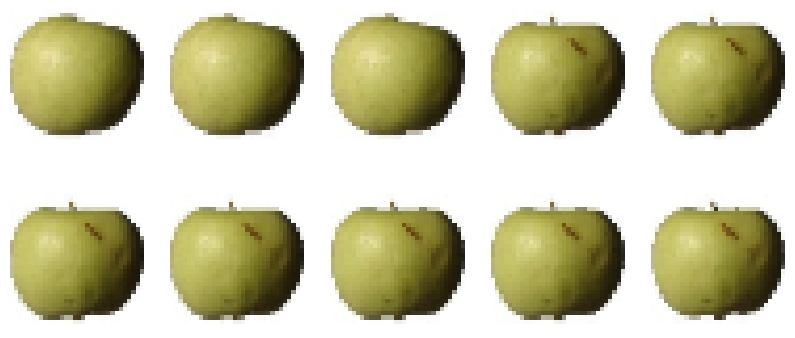

In [37]:
show_images_batch(X_test[resultados[es_Golden3 & (errores == False)].index[0:10]])

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [38]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights=None, input_shape=(32, 32, 3))

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [41]:
earlySFT = EarlyStopping(restore_best_weights= True, patience= 10)

In [43]:
# Entrenamos el modelo
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_s_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=60,
                   callbacks= earlySFT)

print("Tiempo de entrenamiento:", time() - t_zero)

Epoch 1/60
81/81 [==============================] - 49s 511ms/step - loss: 0.4624 - acc: 0.8616 - val_loss: 115.1741 - val_acc: 0.1069
Epoch 2/60
81/81 [==============================] - 38s 471ms/step - loss: 0.2365 - acc: 0.9368 - val_loss: 4.9418 - val_acc: 0.2623
Epoch 3/60
81/81 [==============================] - 37s 463ms/step - loss: 0.1503 - acc: 0.9569 - val_loss: 4.1158 - val_acc: 0.4317
Epoch 4/60
81/81 [==============================] - 38s 472ms/step - loss: 0.2027 - acc: 0.9453 - val_loss: 6.3265 - val_acc: 0.6058
Epoch 5/60
81/81 [==============================] - 38s 475ms/step - loss: 0.1081 - acc: 0.9713 - val_loss: 0.7466 - val_acc: 0.8290
Epoch 6/60
81/81 [==============================] - 43s 537ms/step - loss: 0.1318 - acc: 0.9695 - val_loss: 4.9291 - val_acc: 0.4075
Epoch 7/60
81/81 [==============================] - 38s 470ms/step - loss: 0.3309 - acc: 0.9157 - val_loss: 22.7373 - val_acc: 0.2943
Epoch 8/60
81/81 [==============================] - 38s 465ms/step

In [47]:
df_evol = pd.DataFrame(history.history)

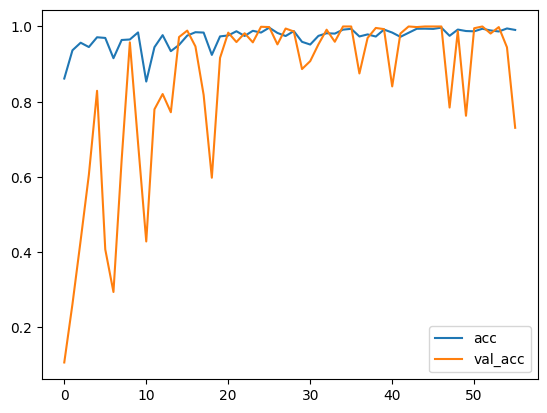

In [48]:
df_evol[["acc","val_acc"]].plot();

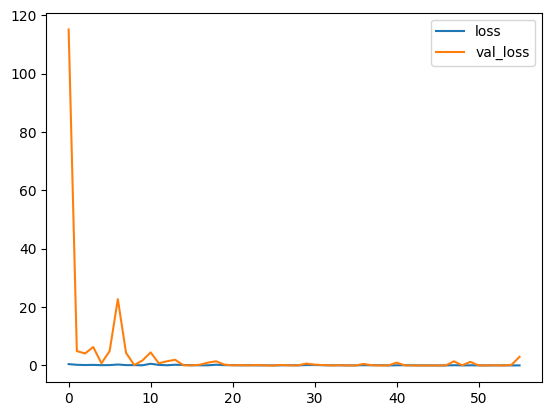

In [49]:
df_evol[["loss","val_loss"]].plot();

Con redes tan grandes y la cantidad de datos que tenemos el problema es que la oscilación de los resultados es tremenda y la sensibilidad a la inicialización también. El modelo tarda en encontrar valores de pérdida bajos para validación y si se repite el entrenamiento puede que tarde mucho más o menos en encontrar valores interesantes. Vendría bien aumentar el batch size para que la selección aleatoria le afecte menos. Lo que sí ocurre es que si escogemos valores bajos de número de épocas es posible que el modelo nunca llegue a "calentar" como para salir de los mínimos locales que ha ido encontrando y no obtenga buenas prestaciones

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [50]:
model.evaluate(X_test, y_test_num)

67/67 [==============================] - 6s 86ms/step - loss: 0.0618 - acc: 0.9808


[0.06175059452652931, 0.9807872772216797]

Obtenemos un *accuracy* del 98%. Para el test set la paciencia y el supermodelo han sido un buenos

In [51]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

67/67 [==============================] - 7s 96ms/step
              precision    recall  f1-score   support

    Braeburn       0.90      0.90      0.90       164
 CrimsonSnow       1.00      1.00      1.00       148
     Golden1       1.00      1.00      1.00       160
     Golden2       1.00      0.99      0.99       164
     Golden3       0.99      1.00      0.99       161
 GrannySmith       1.00      1.00      1.00       164
    PinkLady       1.00      1.00      1.00       152
        Red1       1.00      0.96      0.98       164
        Red2       0.90      0.90      0.90       164
        Red3       0.96      1.00      0.98       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       1.00      1.00      1.00       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.98      2134
   macro avg       0.98      0.98      0.98      2134
weighted avg       0.98      0.98      0.98      2134



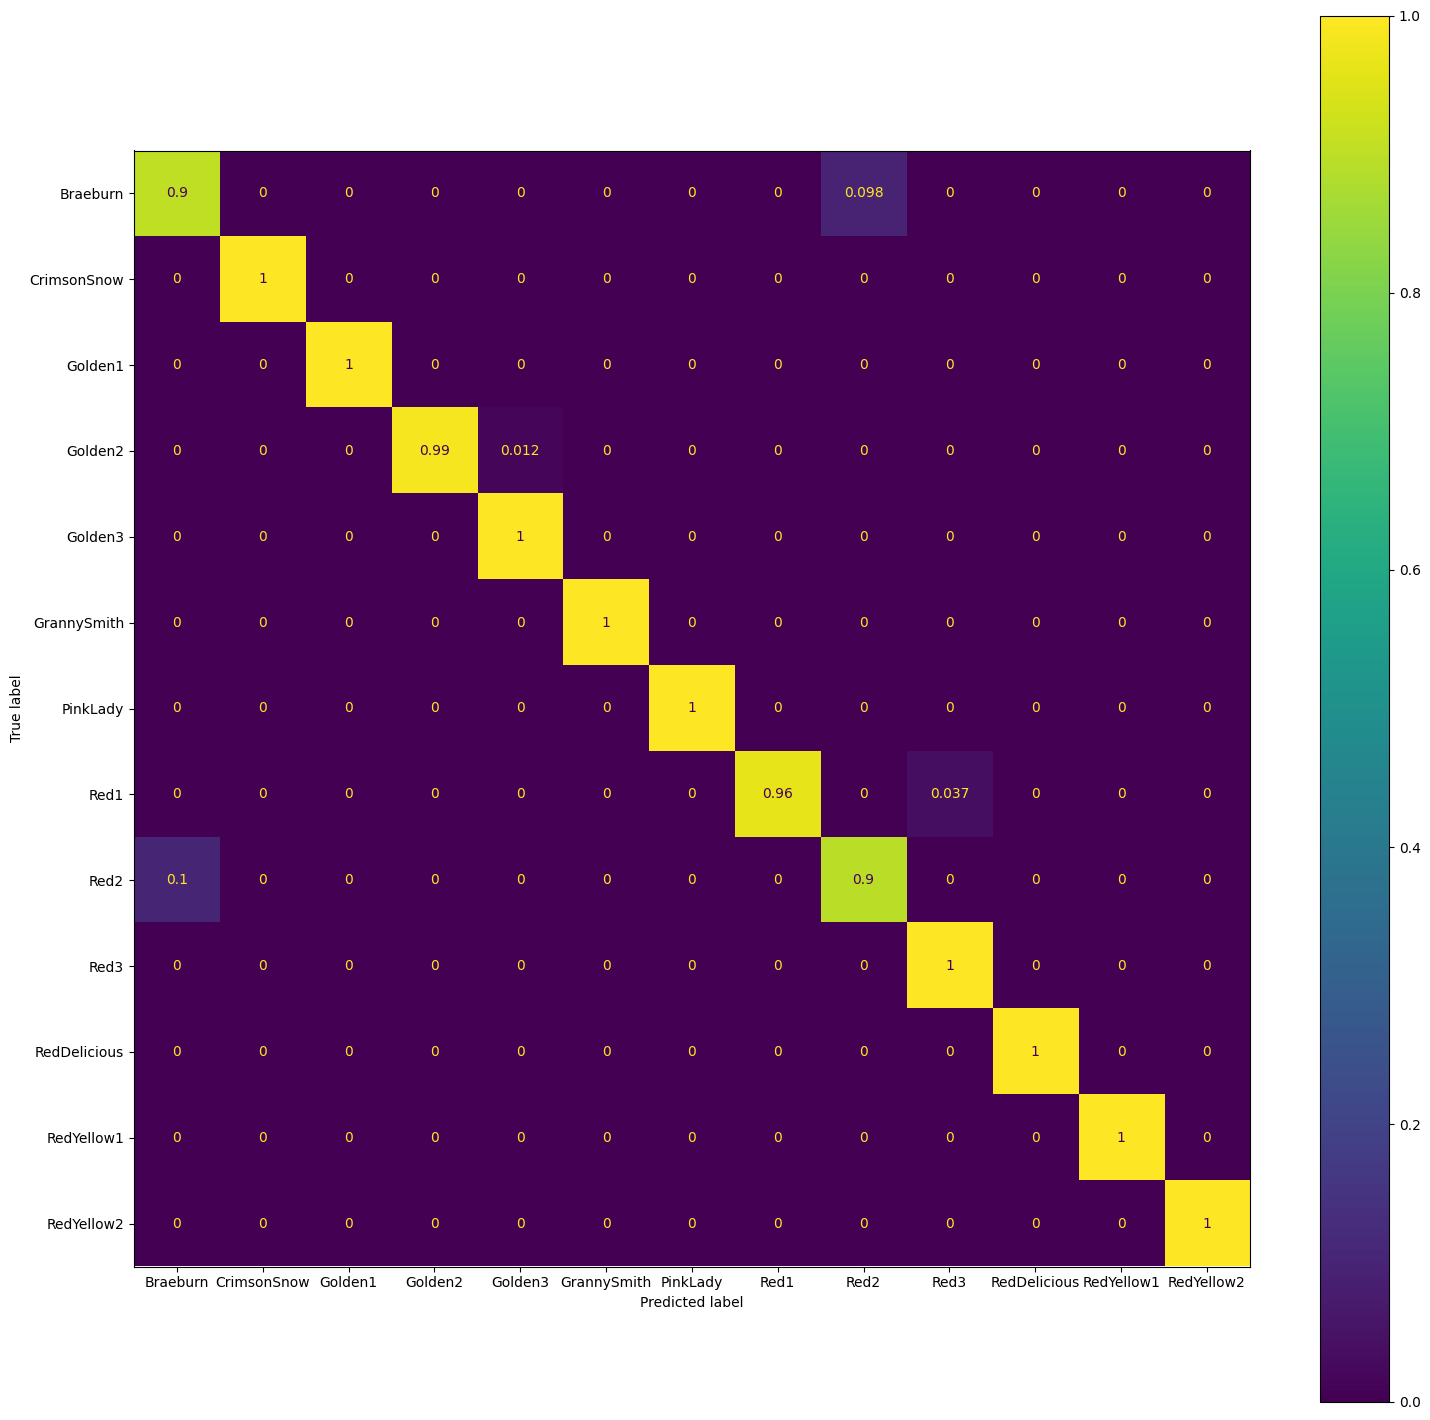

In [53]:
fig,axs = plt.subplots(1,1,figsize = (18,18))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs);

Casi perfecto